# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics

La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/Eduardo/Control/193005_CTRL_Rtn_EMAD_01.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/Eduardo/Control/193005_CTRL_Rtn_EMAD_01"

In [3]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 17855.5
  "DatosCrudos" => UInt16[0x0000, 0x07f1, 0x07fc, 0x07fb, 0x07fb, 0x07f7, 0x07f…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 1071330
  "duracion"    => 60.0

Para archivos monstruosamente grandes, o dividimos automaticamente en cachos todo, o escogemos intervalos interesantes y de ahi trabajamos los cachos.

In [4]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


27

In [5]:
autorebana=false
if autorebana
    tamax=400*1024*1024  #maximo tamaño tolerable de archivo en tu lap
    tam=filesize(abrestring)
    cachos=div(tam,tamax)+1
else
    #tiempos interesantes es una lista de intervalos en segundos. 
tstr="00:01.1-00:02.3
00:04.5-00:05.7
00:08.9-0:11.0
00:15.7-00:16.7
00:18.7-00:20.1
00:23.0-00:24.6
00:33.9-00:34.8
00:38.0-00:39.0
00:42.0-00:43.0
00:47.1-00:48.5
00:51.3-00:52.5
00:54.2-00:55.7
00:58.0-00:59.0"
    tinteres=parseatiempos(tstr, freq)
    cachos=length(tinteres)
end
    

13

In [6]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq; digits=1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 1071330 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  60000.0ms.


In [7]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.34105138874829527

In [8]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

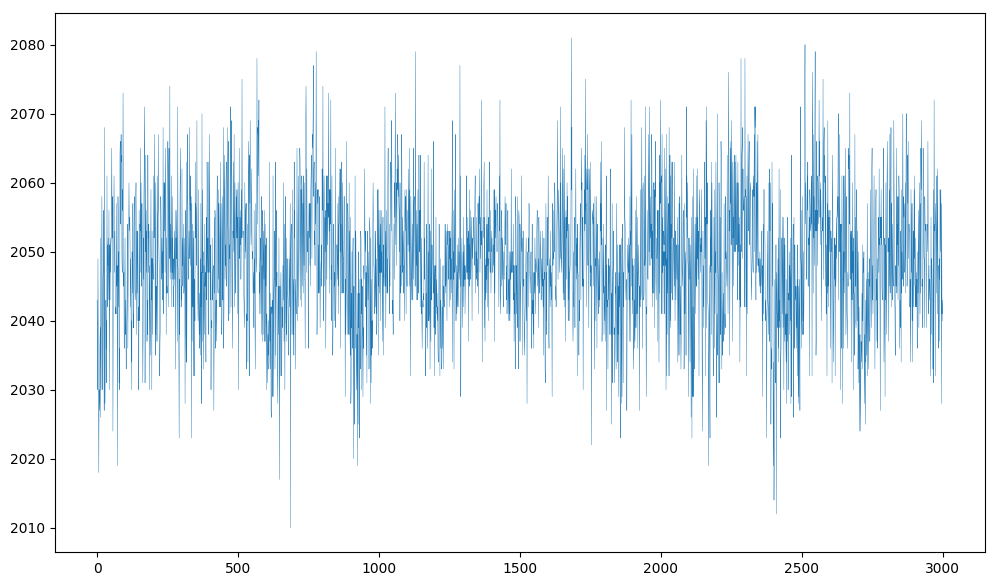

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f78340dff28>

In [9]:
figure(figsize=(12,7))

plot(DatosCrudosArreglados[4,1:3000], lw=0.3)

In [10]:
DatosCrudosArreglados[1,1]==0

true

In [11]:
cachos

13

In [14]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar

dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
indicadorespecifico=".h5"

if cachos > 1
    for cacho in 1:cachos
        if autorebana
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
            pedazo=round(Int, Datos["numcuadros"]/cachos)
            nini=1+(cacho-1)*pedazo
            
            if cacho < cachos # si no es el ultimo cacho
                nfin=cacho*pedazo
            else
                nfin=cuadrosmax
            end
            
        else # si no autorebana   
            q=tinteres[cacho]
            nini=q[1]
            nfin=q[end]
        end 
            
        datosaux=DatosCrudosArreglados[:,nini:nfin]
        palabritaespecial="/Cacho_$(cacho)_"
        DatosCentrados=FormaMatrizDatosCentrados(datosaux, factor);
        intervalo=[nini/freq, nfin/freq]
    
        listaaguardar=Dict(
        "lfp" => DatosCentrados,
         "freq" =>freq,
        "intervalo"=>intervalo)
        
  
        outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)

        h5open(outname, "w")  do file
            for k in keys(listaaguardar)
                datos=listaaguardar[k]
                println("abriendo los datos ", k)
                println
                write(file, "$k", datos)
            end
        end 

        println("hemos guardado este cacho en el archivo ", outname)

        end #CIERRA SOBRE CACHOS
      
    else
       
    palabritaespecial="/Completo_"
    DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
    intervalo=[1/freq, cuadrosmax/freq]
    
      listaaguardar=Dict(
    "lfp" => DatosCentrados,
     "freq" =>freq,
    "intervalo"=>intervalo)
        
  
    outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)

    h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end 

       println("hemos guardado este cacho en el archivo ", outname)
    
 end        
            

#    end;
# Liberar memoria
Datos["DatosCrudos"]=0


abriendo los datos intervalo
abriendo los datos lfp
abriendo los datos freq
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Eduardo/Control/Cacho_1_193005_CTRL_Rtn_EMAD_01.h5
abriendo los datos intervalo
abriendo los datos lfp
abriendo los datos freq
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Eduardo/Control/Cacho_2_193005_CTRL_Rtn_EMAD_01.h5
abriendo los datos intervalo
abriendo los datos lfp
abriendo los datos freq
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Eduardo/Control/Cacho_3_193005_CTRL_Rtn_EMAD_01.h5
abriendo los datos intervalo
abriendo los datos lfp
abriendo los datos freq
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5
abriendo los datos intervalo
abriendo los datos lfp
abriendo los datos freq
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Eduardo/Control/Cacho_5_193005_CTRL_Rtn_EMAD_01.h5
abriendo los datos intervalo
abriendo los datos lfp
abriendo

0

In [ ]:
isdefined(Main, :tinteres)

In [ ]:
?isdefined

In [ ]:
size(DatosCrudosArreglados)

In [ ]:
 @time DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados[:,1:1000], factor);
# libera memoria
#DatosCrudosArreglados=0

In [ ]:
using PyPlot

In [ ]:
exc=DatosCentrados[3,27,:]

In [ ]:
plot(exc)

In [ ]:
exb=DatosCentrados[27,3,:]

In [ ]:
exa=convert.(Float32, DatosCentrados[:,:,300])

In [ ]:
plot(exb)

In [ ]:
v=200
figure(figsize=(9,9))
imshow(exa, vmin=-v, vmax=v)

In [ ]:
@time DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
DatosCrudosArreglados=0

In [ ]:
# De donde a donde quieres recortar
renglonmin=16
renglonmax=50
colmin=32
colmax=64

In [ ]:
A=[1 2 0;0 3 4]

In [ ]:
A[2,1]

In [ ]:
Subdatos=DatosCentrados[renglonmin:renglonmax, colmin:colmax,:];

In [ ]:
round(Sys.free_memory()/Sys.total_memory(),digits=4)

In [ ]:
DatosCentrados=0

In [ ]:
round(Sys.free_memory()/Sys.total_memory(),digits=4)

In [ ]:
ncuadros=size(Subdatos)[3]

In [ ]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=BuscaCanalRespActPot(Subdatos)
# y luego los saturados
iniciobusqueda=2000
finbusqueda=retrazo+10000
Saturados=BuscaSaturados(Subdatos)
numerosaturados=size(Saturados)[1]
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [ ]:
(alto, ancho, nmax)=size(Subdatos)
DesviacionPorCanal=zeros(alto,ancho)
for j=1:alto
    for k=1:ancho
        ChorizoExemplo=vec(Subdatos[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end

In [ ]:
figure(figsize=(7,7))
xlim(0,ancho+1)
ylim(0, alto+1)
title("σ")
limites=50
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="gnuplot", 
                      vmin=10,vmax=limites, extent=[0,ancho+0.5,0,alto+0.5])
cb=colorbar()

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=30)
scatter(x2,y2, marker="o",c="green", s=30)

In [ ]:
alto, ancho

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [ ]:
egtrazo=Subdatos[15,15,:];

In [ ]:
egtrazo[29000:34000];

In [ ]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-100,100)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=29000
hasta=37000
#intervalo=1:cacho
intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo], lw=2)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
indicadorespecifico="_subdatos.h5"
outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPRecortado" => Subdatos,
     "cols" => [colmin, colmax],
      "rengs" => [renglonmin, renglonmax],
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)


In [ ]:
typeof(Subdatos)

In [ ]:
Subdatos=convert.(Float32, Subdatos)